<a href="https://colab.research.google.com/github/top-data/Soil_moisture/blob/main/sm_cosmoz_inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and authentication

In [2]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import geemap
from datetime import datetime, timedelta


# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize(project='ee-mhdsaki')

# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Converting image to dataframe

In [3]:
# image to df converter function

def image_to_df(sat_product, bands, gps, dates):
    """
    Inputs: satellite data product, desired bands, gps, date
    Output: pandas dataframe with selected bands and date
    Returns:

    """
    # Define the ImageCollection
    image = ee.ImageCollection(sat_product) \
              .select(bands) \
              .filterDate(dates[0], dates[1])

    # Define a global bounding box geometry
    global_geometry = ee.Geometry.Polygon(
        [[[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]]
    )

    # Define a local bounding box geometry
    local_geometry = ee.Geometry.Rectangle([30, -10, 40, 10])

    # Define a single geometry
    single_geometry = ee.Geometry.Point(gps)

    # Function to extract the date and mean values of bands
    def image_to_dict(image):
        # Get the date of the image
        date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
        # Get the mean soil moisture values over the global geometry
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=single_geometry, # or local_geometry # or global_geometry
            scale=10000,
            maxPixels=1e9
        )
        # Create a dictionary to store the data
        data = {'date': date}
        # Iterate over the bands and add their values to the dictionary
        for band in bands:
            data[band] = stats.get(band)
        return ee.Feature(None, data)

    # Map the function over the ImageCollection
    data_features = image.map(image_to_dict)

    # Convert the ImageCollection to a FeatureCollection, then to a list of dictionaries
    features_dicts = data_features.getInfo()['features']

    # Convert to pandas DataFrame
    data_dict = [{'date': f['properties']['date'],
                  **{band: f['properties'][band] for band in bands}} for f in features_dicts]

    df = pd.DataFrame(data_dict)

    return df




# Loading data

## Loading satellite data



## List of sites for in-situ soil moisture

In [56]:
stations = {
    'site_no': ['station6', 'station7', 'station8', 'station10', 'station10', 'station15', 'station18', 'station19', 'station21', 'station23', 'station25', 'station26', 'station27', 'station29', 'station32'],
    'site_name': ['RobsonCk', 'Temora', 'Tullochgorum', 'WeanyCk', 'Yanco', 'Hamilton', 'Bishes', 'Bennets', 'Bullawarrie', 'BCS_Conservatively', 'BCS_Brigalow', 'BCS_Heavily', 'Boorowa', 'Credo', 'OakValley'],
    'lat':[-17.116, -34.405, -41.669, -19.882, -35.005, -37.828, -35.769, -35.826, -28.809, -24.812, -24.815, -24.811, -34.471, -30.191, -19.439],
    'lon': [145.630, 147.533, 147.912, 146.536, 146.299, 142.089, 142.973, 143.004, 148.765, 149.801, 149.794, 149.790, 148.697, 120.654, 146.827]
    }

stations_df = pd.DataFrame(stations)
stations_df


,site_no,site_name,lat,lon
0,station6,RobsonCk,-17.116,145.630
1,station7,Temora,-34.405,147.533
2,station8,Tullochgorum,-41.669,147.912
3,station10,WeanyCk,-19.882,146.536
4,station10,Yanco,-35.005,146.299
5,station15,Hamilton,-37.828,142.089
6,station18,Bishes,-35.769,142.973
7,station19,Bennets,-35.826,143.004
8,station21,Bullawarrie,-28.809,148.765
9,station23,BCS_Conservatively,-24.812,149.801


In [4]:

# Function to download data for a specific period
def download_smap_data(start_date, end_date, sat_product, bands, gps):
    dates = [start_date, end_date]
    return image_to_df(sat_product, bands, gps, dates)

# Parameters
sat_product = 'NASA/SMAP/SPL4SMGP/007'
bands = ['sm_surface', 'sm_rootzone', 'sm_profile', 'sm_surface_wetness', 'sm_rootzone_wetness', 'sm_profile_wetness', 'surface_temp',
         'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3', 'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6']
gps = [147.533, -34.405] # station7 (site: Temora)
start_date = datetime(2020, 8, 15)
end_date = datetime(2024, 8, 15)

# Empty list to store DataFrames
dfs = []

# Loop through the date range in 3-month intervals
current_start = start_date
while current_start < end_date:
    current_end = min(current_start + timedelta(days=90), end_date)
    df = download_smap_data(current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d'), sat_product, bands, gps)
    dfs.append(df)
    current_start = current_end

# Combine all DataFrames into one
smap_df = pd.concat(dfs)

# Process the combined DataFrame
smap_df['date'] = pd.to_datetime(smap_df['date'])  # Convert 'date' to datetime
smap_df.set_index('date', inplace=True)  # Set 'date' as index

# Display the final DataFrame
smap_df.tail()


,sm_surface,sm_rootzone,sm_profile,sm_surface_wetness,sm_rootzone_wetness,sm_profile_wetness,surface_temp,soil_temp_layer1,soil_temp_layer2,soil_temp_layer3,soil_temp_layer4,soil_temp_layer5,soil_temp_layer6
date,,,,,,,,,,,,,
2024-08-11,0.074017,0.204315,0.214157,0.164190,0.453228,0.475061,282.354889,281.881561,283.939423,283.765930,284.666473,287.563812,289.830078
2024-08-12,0.075576,0.204292,0.214100,0.167648,0.453177,0.474933,292.153656,284.673553,283.811249,283.784241,284.671631,287.558807,289.829742
2024-08-12,0.075882,0.204109,0.213956,0.168327,0.452771,0.474613,294.410797,288.152283,284.151276,283.804962,284.676849,287.553802,289.829559
2024-08-12,0.078166,0.204108,0.213911,0.173394,0.452769,0.474514,289.402069,288.865570,284.708130,283.841248,284.682220,287.548859,289.829254
2024-08-12,0.060279,0.203330,0.213362,0.133716,0.451042,0.473297,283.175110,285.608582,285.185028,283.949829,284.693939,287.539032,289.828766


In [7]:
smap_df.dropna(inplace=True)
smap_df.info()
smap_df.to_csv('/content/drive/MyDrive/SoilMoisture/smap_df_station7.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11658 entries, 2020-08-15 to 2024-08-12
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sm_surface           11658 non-null  float64
 1   sm_rootzone          11658 non-null  float64
 2   sm_profile           11658 non-null  float64
 3   sm_surface_wetness   11658 non-null  float64
 4   sm_rootzone_wetness  11658 non-null  float64
 5   sm_profile_wetness   11658 non-null  float64
 6   surface_temp         11658 non-null  float64
 7   soil_temp_layer1     11658 non-null  float64
 8   soil_temp_layer2     11658 non-null  float64
 9   soil_temp_layer3     11658 non-null  float64
 10  soil_temp_layer4     11658 non-null  float64
 11  soil_temp_layer5     11658 non-null  float64
 12  soil_temp_layer6     11658 non-null  float64
dtypes: float64(13)
memory usage: 1.2 MB


## Loading ground truth soil moisture data


In [8]:
staion7_soilM = pd.read_csv('/content/drive/MyDrive/SoilMoisture/cosmoz/station7_level4_4y.csv')
staion7_soilM = staion7_soilM.rename(columns={'UTC_TIMESTAMP': 'date'})
staion7_soilM['date'] = pd.to_datetime(staion7_soilM['date'])
staion7_soilM.set_index('date', inplace=True)
staion7_soilM.tail()

,SOIL_MOISTURE_percent,EFFECTIVE_DEPTH_cm,RAIN_mm,7H_SOIL_MOISTURE_percent,7H_DEPTH_cm
date,,,,,
2024-08-14 22:57:27,17.695,18.467,0.0,25.469,14.956
2024-08-14 23:57:24,26.879,14.289,0.0,24.053,15.548
2024-08-15 00:57:23,22.851,15.863,0.0,23.754,15.695
2024-08-15 01:57:23,26.679,14.360,0.0,22.608,16.149
2024-08-15 02:57:28,18.936,17.765,0.0,23.837,15.569


## Resmpling and merging satellite and in-situ data

In [9]:
# Resample smap_df to daily and average values
smap_df_daily = smap_df.resample('D').mean()

# Resample staion7_soilM to daily and average values
staion7_soilM_daily = staion7_soilM.resample('D').mean()/100

# Merge the two dataframes on 'date'
merged_df = pd.merge(smap_df_daily, staion7_soilM_daily, on='date', how='inner')

# Display the merged dataframe
merged_df.tail()


,sm_surface,sm_rootzone,sm_profile,sm_surface_wetness,sm_rootzone_wetness,sm_profile_wetness,surface_temp,soil_temp_layer1,soil_temp_layer2,soil_temp_layer3,soil_temp_layer4,soil_temp_layer5,soil_temp_layer6,SOIL_MOISTURE_percent,EFFECTIVE_DEPTH_cm,RAIN_mm,7H_SOIL_MOISTURE_percent,7H_DEPTH_cm
date,,,,,,,,,,,,,,,,,,
2024-08-08,0.088374,0.207438,0.217246,0.196038,0.460155,0.481912,283.741199,282.887909,282.245911,282.728775,284.640808,287.709934,289.836704,0.196366,0.175172,0.0,0.197581,0.174465
2024-08-09,0.083956,0.206491,0.216381,0.186238,0.458056,0.479994,284.630093,284.171978,283.307697,282.974625,284.623230,287.666054,289.834778,0.203910,0.171166,0.0,0.203541,0.171588
2024-08-10,0.069870,0.205044,0.215186,0.154992,0.454845,0.477342,284.580662,284.376812,283.826351,283.313801,284.627003,287.623135,289.832851,0.195884,0.176491,0.0,0.196889,0.175697
2024-08-11,0.065074,0.204098,0.214214,0.144351,0.452747,0.475186,285.370098,284.862183,284.160950,283.620682,284.651058,287.581577,289.830906,0.209917,0.167837,0.0,0.210160,0.167885
2024-08-12,0.072476,0.203960,0.213832,0.160771,0.452440,0.474339,289.785408,286.824997,284.463921,283.845070,284.681160,287.550125,289.829330,0.202438,0.172398,0.0,0.200537,0.173485


In [10]:
merged_df.corr()['SOIL_MOISTURE_percent'].sort_values(ascending=False)

,SOIL_MOISTURE_percent
SOIL_MOISTURE_percent,1.000000
7H_SOIL_MOISTURE_percent,0.999838
sm_surface,0.809144
sm_surface_wetness,0.809141
sm_rootzone,0.721056
sm_rootzone_wetness,0.721056
sm_profile,0.687371
sm_profile_wetness,0.687368
RAIN_mm,0.221526
soil_temp_layer6,0.091187


## Plot (satellite and in-situ)

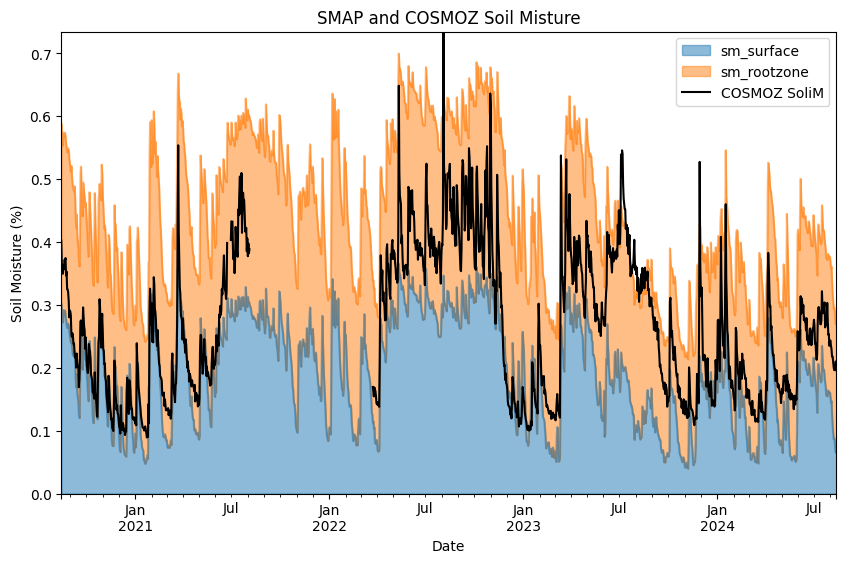

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot stacked area chart for col1 and col2
merged_df[['sm_surface', 'sm_rootzone']].plot(kind='area', stacked=True, ax=ax1, alpha=0.5)

# Plot line plot for col3
ax1.plot(merged_df.index, merged_df['SOIL_MOISTURE_percent'], color='black', label='COSMOZ SoliM')


# Add labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Soil Moisture (%)')

# Add legends
ax1.legend(loc='upper right')

# Show plot
plt.title('SMAP and COSMOZ Soil Misture')
plt.show()


## Cleaning data

In [12]:
merged_df.dropna(subset=['SOIL_MOISTURE_percent'], inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1221 entries, 2020-08-15 to 2024-08-12
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sm_surface                1221 non-null   float64
 1   sm_rootzone               1221 non-null   float64
 2   sm_profile                1221 non-null   float64
 3   sm_surface_wetness        1221 non-null   float64
 4   sm_rootzone_wetness       1221 non-null   float64
 5   sm_profile_wetness        1221 non-null   float64
 6   surface_temp              1221 non-null   float64
 7   soil_temp_layer1          1221 non-null   float64
 8   soil_temp_layer2          1221 non-null   float64
 9   soil_temp_layer3          1221 non-null   float64
 10  soil_temp_layer4          1221 non-null   float64
 11  soil_temp_layer5          1221 non-null   float64
 12  soil_temp_layer6          1221 non-null   float64
 13  SOIL_MOISTURE_percent     1221 non-null   flo

# Modelling

## Data Preparation

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, MultiHeadAttention, Input, Dropout, Flatten
from xgboost import XGBRegressor



# Prepare features and target
X = merged_df[bands].values
y = merged_df['SOIL_MOISTURE_percent'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Transformer Model with MultiHeadAttention

In [14]:
import tensorflow as tf

# Define Transformer model
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Reshape data for transformer model
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

transformer_model = build_transformer_model((1, X_train_scaled.shape[1]))
transformer_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0403 - val_loss: 0.0036
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0018


## LSTM Model

In [15]:
# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Reshape data for LSTM model
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = build_lstm_model((1, X_train_scaled.shape[1]))
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0263 - val_loss: 0.0054
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0020


## XGBoost Model

In [16]:
# Define and train XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Evaluation

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Function to evaluate the model

def evaluate_model(model, X_test, y_test, model_type='keras'):
    if model_type == 'keras':
        y_pred = model.predict(X_test).flatten()
    elif model_type == 'xgboost':
        y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return mse, rmse, r2
# Evaluate Transformer model
transformer_mse, transformer_rmse, transformer_r2 = evaluate_model(transformer_model, X_test_reshaped, y_test, model_type='keras')

# Evaluate LSTM model
lstm_mse, lstm_rmse, lstm_r2 = evaluate_model(lstm_model, X_test_lstm, y_test, model_type='keras')

# Evaluate XGBoost model
xgb_mse, xgb_rmse, xgb_r2 = evaluate_model(xgb_model, X_test_scaled, y_test, model_type='xgboost')

# Create a DataFrame to show the results
results_df = pd.DataFrame({
    'Model': ['Transformer', 'LSTM', 'XGBoost'],
    'MSE': [transformer_mse, lstm_mse, xgb_mse],
    'RMSE': [transformer_rmse, lstm_rmse, xgb_rmse],
    'R-Squared': [transformer_r2, lstm_r2, xgb_r2]
})

results_df


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


,Model,MSE,RMSE,R-Squared
0,Transformer,0.001656,0.040699,0.883031
1,LSTM,0.001738,0.041688,0.877281
2,XGBoost,0.001134,0.033671,0.919943


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


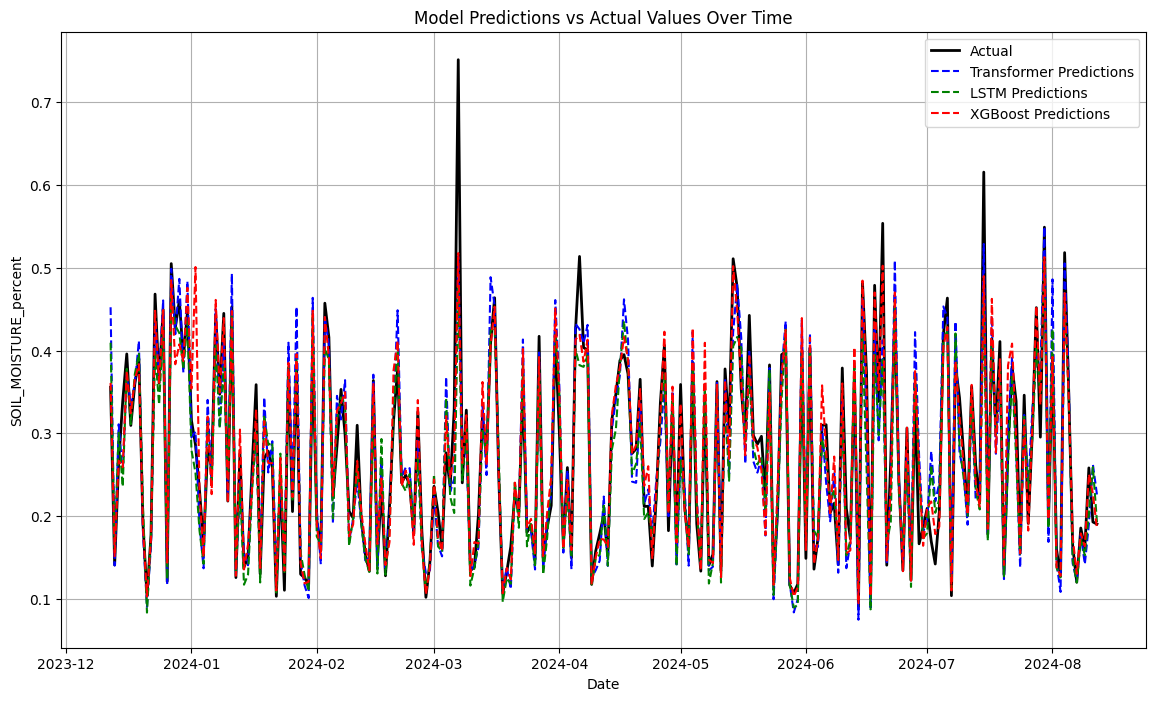

In [18]:
import matplotlib.pyplot as plt

# Get corresponding dates for y_test
test_dates = merged_df.index[-len(y_test):]

# Generate predictions
transformer_predictions = transformer_model.predict(X_test_reshaped).flatten()
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()
xgb_predictions = xgb_model.predict(X_test_scaled)

# Plot the actual values and predictions vs date
plt.figure(figsize=(14, 8))

plt.plot(test_dates, y_test, label='Actual', color='black', linewidth=2)
plt.plot(test_dates, transformer_predictions, label='Transformer Predictions', color='blue', linestyle='--')
plt.plot(test_dates, lstm_predictions, label='LSTM Predictions', color='green', linestyle='--')
plt.plot(test_dates, xgb_predictions, label='XGBoost Predictions', color='red', linestyle='--')

plt.title('Model Predictions vs Actual Values Over Time')
plt.xlabel('Date')
plt.ylabel('SOIL_MOISTURE_percent')
plt.legend()
plt.grid(True)
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


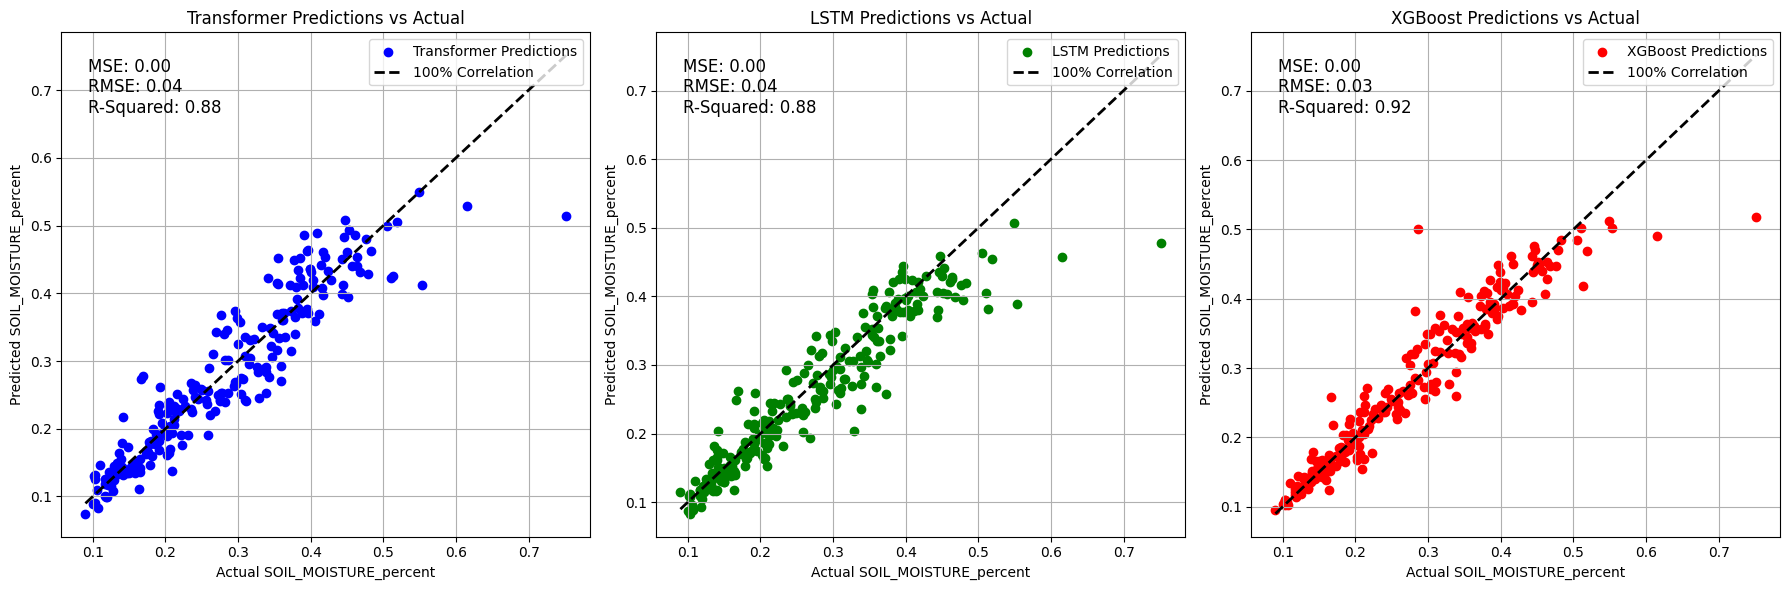

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Generate predictions
transformer_predictions = transformer_model.predict(X_test_reshaped).flatten()
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()
xgb_predictions = xgb_model.predict(X_test_scaled)

# Calculate MSE, RMSE, and R-Squared for each model
transformer_mse = mean_squared_error(y_test, transformer_predictions)
transformer_rmse = np.sqrt(transformer_mse)
transformer_r2 = r2_score(y_test, transformer_predictions)

lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test, lstm_predictions)

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Plot scatter plots
plt.figure(figsize=(18, 6))

# Transformer model
plt.subplot(1, 3, 1)
plt.scatter(y_test, transformer_predictions, color='blue', label='Transformer Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('Transformer Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {transformer_mse:.2f}\nRMSE: {transformer_rmse:.2f}\nR-Squared: {transformer_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

# LSTM model
plt.subplot(1, 3, 2)
plt.scatter(y_test, lstm_predictions, color='green', label='LSTM Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {lstm_mse:.2f}\nRMSE: {lstm_rmse:.2f}\nR-Squared: {lstm_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

# XGBoost model
plt.subplot(1, 3, 3)
plt.scatter(y_test, xgb_predictions, color='red', label='XGBoost Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {xgb_mse:.2f}\nRMSE: {xgb_rmse:.2f}\nR-Squared: {xgb_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


# Saving the pipeline

## Create the pipline class

In [22]:
import joblib
import numpy as np
from tensorflow.keras.models import load_model

class SoilMoisturePredictor:
    def __init__(self, scaler, model):
        self.scaler = scaler
        self.model = model

    def preprocess(self, X):
        # Scale the input features
        X_scaled = self.scaler.transform(X)
        # Reshape for Transformer model
        X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
        return X_reshaped

    def predict(self, X):
        # Preprocess the input
        X_preprocessed = self.preprocess(X)
        # Make predictions using the model
        predictions = self.model.predict(X_preprocessed)
        return predictions

    def save(self, filepath):
        # Save the scaler and model
        joblib.dump(self.scaler, f'{filepath}_scaler.pkl')
        # save_model(self.model, f'{filepath}_model.h5')
        self.model.save(f'{filepath}_model.keras')

    @classmethod
    def load(cls, filepath):
        # Load the scaler and model
        scaler = joblib.load(f'{filepath}_scaler.pkl')
        # model = load_model(f'{filepath}_model.h5')
        model = load_model(f'{filepath}_model.keras')
        return cls(scaler, model)


## Save the pipline

In [23]:
# Create an instance of SoilMoisturePredictor
predictor = SoilMoisturePredictor(scaler=scaler, model=transformer_model)

# Save the predictor instance
model_path = '/content/drive/MyDrive/SoilMoisture/soil_moisture_predictor'
predictor.save(model_path)



## Save the xgb pipeline

In [24]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Example Preprocessing and Model Pipeline
xgb_pipeline = Pipeline([
    ('scaler', scaler),  # Add other preprocessing steps if necessary
    ('xgb_model', xgb_model)  # Replace with the trained XGBoost model
])

model_path = '/content/drive/MyDrive/SoilMoisture/'

# Save the pipeline
joblib.dump(xgb_pipeline, f'{model_path}xgb_pipeline.pkl')


['/content/drive/MyDrive/SoilMoisture/xgb_pipeline.pkl']

# Load and Use the Encapsulated Model

### Load new satellite data for a different location (site)

In [27]:
# Parameters
sat_product = 'NASA/SMAP/SPL4SMGP/007'

bands = ['sm_surface', 'sm_rootzone', 'sm_profile', 'sm_surface_wetness', 'sm_rootzone_wetness', 'sm_profile_wetness', 'surface_temp',
         'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3', 'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6']

gps = [146.299, -35.005] # station11 (site: Yanco)
start_date = datetime(2023, 8, 15)
end_date = datetime(2024, 8, 15)

# Empty list to store DataFrames
dfs = []

# Loop through the date range in 3-month intervals
current_start = start_date
while current_start < end_date:
    current_end = min(current_start + timedelta(days=90), end_date)
    df = download_smap_data(current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d'), sat_product, bands, gps)
    dfs.append(df)
    current_start = current_end

# Combine all DataFrames into one
smap_df_new = pd.concat(dfs)

# Process the combined DataFrame
smap_df_new['date'] = pd.to_datetime(smap_df_new['date'])  # Convert 'date' to datetime
smap_df_new.set_index('date', inplace=True)  # Set 'date' as index


In [28]:
smap_df_new.to_csv('/content/drive/MyDrive/SoilMoisture/smap_df_station11.csv')

## Load the transformer model and predict new data

In [38]:
model_path = '/content/drive/MyDrive/SoilMoisture/soil_moisture_predictor'

# Load the predictor instance
model_transformer = SoilMoisturePredictor.load(model_path)

# Resample smap_df to daily and average values
smap_df_daily_new = smap_df_new.resample('D').mean()


# Prepare input for prediction
X_new = smap_df_daily_new[bands].values

# Make predictions using the loaded predictor
transformer_predictions_new = model_transformer.predict(X_new)



/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/12 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


## Load the xgb model and predict new data

In [36]:
model_path = '/content/drive/MyDrive/SoilMoisture/'

# Load the pipeline
xgb_pipeline = joblib.load(f'{model_path}xgb_pipeline.pkl')

# Use the pipeline to predict on new data
xgb_predictions_new = xgb_pipeline.predict(X_new)  # new_data will be automatically scaled using the fitted scaler


### Loading in-situ for new data

In [30]:
staion11_soilM = pd.read_csv('/content/drive/MyDrive/SoilMoisture/cosmoz/station11_level4_1y.csv')
staion11_soilM = staion11_soilM.rename(columns={'UTC_TIMESTAMP': 'date'})
staion11_soilM['date'] = pd.to_datetime(staion11_soilM['date'])
staion11_soilM.set_index('date', inplace=True)
staion11_soilM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8778 entries, 2023-08-15 06:24:08 to 2024-08-15 04:13:38
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SOIL_MOISTURE_percent     8778 non-null   float64
 1   EFFECTIVE_DEPTH_cm        8778 non-null   float64
 2   RAIN_mm                   8778 non-null   float64
 3   7H_SOIL_MOISTURE_percent  8778 non-null   float64
 4   7H_DEPTH_cm               8778 non-null   float64
dtypes: float64(5)
memory usage: 411.5 KB


### Resampling and merging new data

In [40]:

# Resample staion7_soilM to daily and average values
staion11_soilM_daily = staion11_soilM.resample('D').mean()/100

# Merge the two dataframes on 'date'
merged_df_new = pd.merge(smap_df_daily_new, staion11_soilM_daily, on='date', how='inner')


# Display the merged dataframe
merged_df_new.tail()

,sm_surface,sm_rootzone,sm_profile,sm_surface_wetness,sm_rootzone_wetness,sm_profile_wetness,surface_temp,soil_temp_layer1,soil_temp_layer2,soil_temp_layer3,soil_temp_layer4,soil_temp_layer5,soil_temp_layer6,SOIL_MOISTURE_percent,EFFECTIVE_DEPTH_cm,RAIN_mm,7H_SOIL_MOISTURE_percent,7H_DEPTH_cm
date,,,,,,,,,,,,,,,,,,
2024-08-08,0.162131,0.219471,0.229325,0.359652,0.486848,0.508706,284.248528,283.553940,283.090546,283.584347,285.312046,288.281891,290.508102,0.324797,0.122840,0.0,0.320856,0.123907
2024-08-09,0.161836,0.218925,0.228761,0.358998,0.485636,0.507456,285.265198,284.808247,284.039551,283.789055,285.302616,288.240368,290.506126,0.298267,0.129833,0.0,0.300639,0.129160
2024-08-10,0.156489,0.218055,0.228005,0.347135,0.483707,0.505779,285.239094,285.002403,284.537746,284.092106,285.311031,288.199818,290.504059,0.292472,0.134148,0.0,0.292606,0.133719
2024-08-11,0.146575,0.216936,0.227092,0.325144,0.481225,0.503754,285.794712,285.363602,284.795849,284.365692,285.337177,288.160587,290.501999,0.356514,0.115435,0.0,0.352479,0.117051
2024-08-12,0.142382,0.216215,0.226396,0.315842,0.479625,0.502208,287.065781,286.340179,285.322422,284.635422,285.377296,288.122910,290.499847,0.339771,0.119123,0.0,0.339940,0.119096


### Plot the predictions for new data vs in-situ

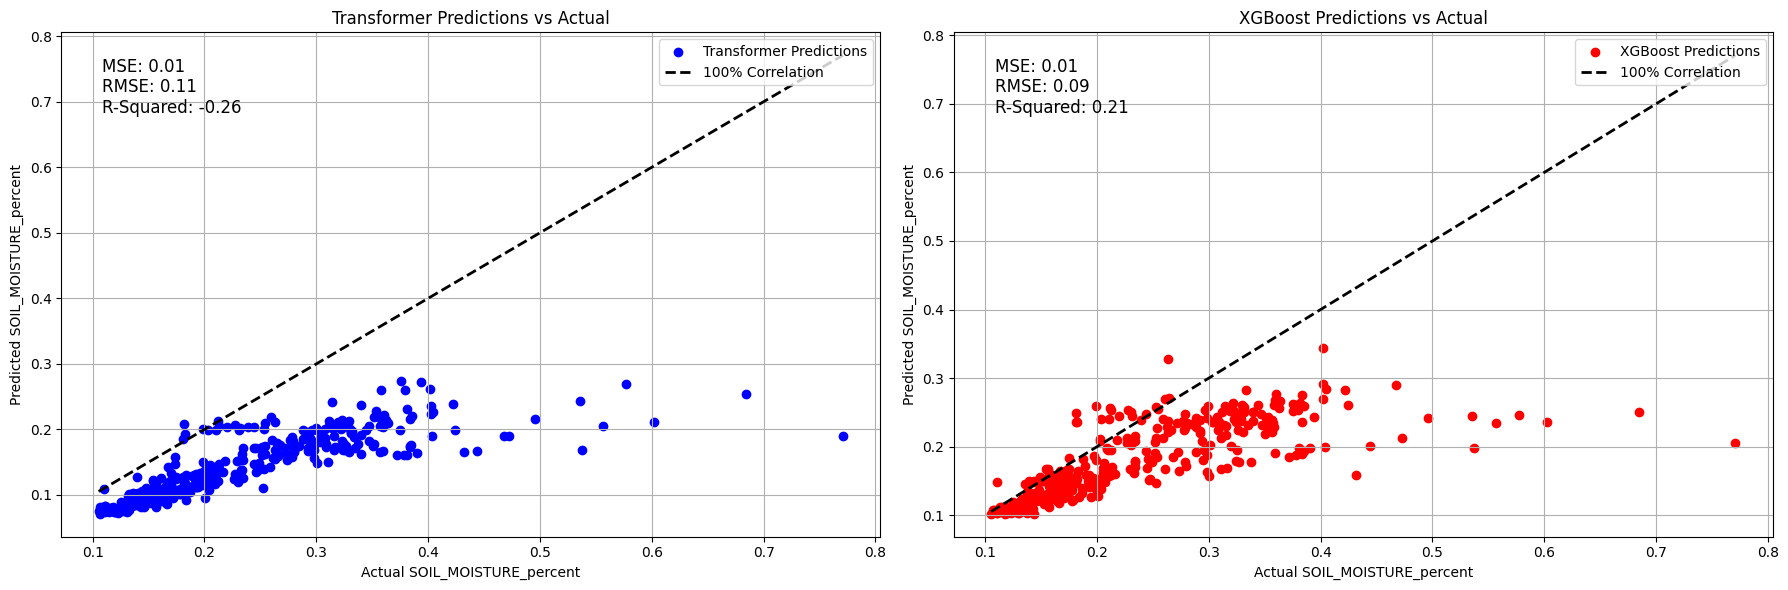

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_test = merged_df_new['SOIL_MOISTURE_percent']

# Generate predictions
transformer_predictions = transformer_predictions_new.flatten()
xgb_predictions = xgb_predictions_new

# Calculate MSE, RMSE, and R-Squared for each model
transformer_mse = mean_squared_error(y_test, transformer_predictions)
transformer_rmse = np.sqrt(transformer_mse)
transformer_r2 = r2_score(y_test, transformer_predictions)


xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Plot scatter plots
plt.figure(figsize=(18, 6))

# Transformer model
plt.subplot(1, 2, 1)
plt.scatter(y_test, transformer_predictions, color='blue', label='Transformer Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('Transformer Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {transformer_mse:.2f}\nRMSE: {transformer_rmse:.2f}\nR-Squared: {transformer_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)


# XGBoost model
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_predictions, color='red', label='XGBoost Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {xgb_mse:.2f}\nRMSE: {xgb_rmse:.2f}\nR-Squared: {xgb_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:


# # Plot the actual values and predictions vs date
# plt.figure(figsize=(14, 8))

# plt.plot(merged_df.index, merged_df['SOIL_MOISTURE_percent'], label='SoilM (in-situ)', color='black', linewidth=2)
# plt.plot(merged_df.index, transformer_predictions, label='SoilM (predicted)', color='blue', linestyle='--')
# plt.plot(merged_df.index, merged_df['sm_surface'], label='sm_surface', linewidth=2)
# plt.plot(merged_df.index, merged_df['sm_rootzone'], label='sm_rootzone', linewidth=2)



# plt.title('Model Predictions vs Actual Values Over Time')
# plt.xlabel('Date')
# plt.ylabel('Soil Moisture (%)')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# import seaborn as sns

# df = merged_df.copy()
# df['predicted_soilM'] = fresh_predictions
# df['surface_actual'] = df['SOIL_MOISTURE_percent'] - df['sm_surface']
# df['root_actual'] = df['SOIL_MOISTURE_percent'] - df['sm_rootzone']
# df['pred_actual'] = df['SOIL_MOISTURE_percent'] - df['predicted_soilM']

# # Plotting the box plots
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df[['pred_actual', 'surface_actual', 'root_actual']])
# plt.title('Box Plots of Soil Moisture Differences')
# # plt.xlabel('Soil elements')
# plt.ylabel('Error Distribution')
# plt.show()

In [ ]:
df[['SOIL_MOISTURE_percent', 'sm_surface', 'sm_rootzone', 'predicted_soilM']].corr()['SOIL_MOISTURE_percent'].sort_values(ascending=False)